# Quantum Circuit Simulator to Model Grover's Algorithm
### James Saslow
### 6/23/2023

Creating a Quantum Circuit Simulator just using matrix algebra to model iterations of Grover's algorithm without Qiskit

In [1]:
# Importing Packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

In [2]:
#------------------------------------------------------
# Quantum Visualization Functions
#------------------------------------------------------

# Making a function that converts base 10 to base 2 and uses braket notation
def base10to2(number,num_qubits):
    bin1 = bin(number)[2:]
    L = num_qubits - len(bin1)
    bin2 = L*'0' + bin1
    return '|' + bin2 + '>'


# Plots a histogram of wavefunction probabilities
def ProbHist(psi):
    num_bases = len(psi)
    num_qubits = int(np.log2(num_bases))
    names10= np.arange(0,num_bases+1,1)
    names = []
    for i in range(num_bases):
        names.append(base10to2(i,num_qubits))
        
    probs = np.abs(psi)**2
    plt.bar(names,probs, width = 0.5)
    plt.grid()
    plt.title('Probabilities of Measurement')
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.show()
    
    

# A function that plots psi and returns which states are filtered and the color code associated with them
def PlotPsi(psi, **kwargs):
    '''
    ====================================================================================================
    Description
    Takes in an arguement psi and returns a scatter plot in complex amplitude space
    =====================================================================================================
    Argument
    psi : the wavefunction
    =====================================================================================================
    **kwargs
    info : returns the filtered unique states of psi and associated color codes of each filtered state
    =====================================================================================================
    '''
    
    N = len(psi)
    # Generating name tags for each basis vector
    states = []
    for i in range(N):
        states.append(base10to2(i,num_qubits))
    
    # Detecting Duplicates
    delete_array = []
    for i in range(len(psi)):
        for j in range(len(psi)):
            if i == j:
                continue
            if np.round(psi[i],5) == np.round(psi[j],5):
                if i not in delete_array and j not in delete_array:
                    delete_array.append(j)
                    
    # Filtering out duplicates
    psi_filtered = np.delete(psi, delete_array)
    N_filtered   = len(psi_filtered)
    states_filtered = np.delete(states, delete_array)

    # Selecting Real and Imaginary Components
    x = np.real(psi_filtered)
    y = np.imag(psi_filtered)
    
    theta_circ = np.linspace(0,2*np.pi,100)
    r_circ = 1/np.sqrt(N)
    x_circ = r_circ*np.cos(theta_circ)
    y_circ = r_circ*np.sin(theta_circ)
    
    colormap = plt.get_cmap('brg')
    colors = colormap(np.linspace(0, 1, N_filtered))
    
    if 'info' in kwargs:
        return states_filtered.tolist(), colors 
    else:
        fig, ax = plt.subplots(figsize = (7.5,7.5))
        plt.title('Amplitude Plot', size = 15)
        plt.scatter(x,y, c=colors, s = 60) # Scattering Points for Each State
        plt.plot(x_circ, y_circ, color = 'black', alpha = 0.3) # Plotting a Unit Circle
        plt.plot([0],[0], marker = '+', linestyle = '', color = 'red', markersize = 20)
        plt.xlabel('$Re$', size = '15')
        plt.ylabel('$Im$', size = '15')
        plt.grid()
        plt.show()
        
        
    
# A function that returns a pandas dataframe of the wavefunction with color 
# coordinated wavefunctions to match the output of PsiPlot
def PrintPsi(psi):
    '''
    ====================================================================================================
    Description
    Takes in an arguement psi and returns a pandas dataframe of information about a state
    =====================================================================================================
    Argument
    psi : the wavefunction
    =====================================================================================================
    '''
    states_filtered, colors = PlotPsi(psi, info=True)
    num_bases = len(psi)
    # Generating name tags for each basis vector
    states = []
    for i in range(num_bases):
        states.append(base10to2(i,num_qubits))


    # f strings?... do something to format decimal places
    df = pd.DataFrame({'State': states,'Magnitude': np.round(abs(psi),5), 'Probability': np.round(abs(psi)**2,5),
                       'Phase': np.round(np.angle(psi),4)})


    # Converting from RGB to Hex
    colors_hex = []
    for i in range(len(colors)):
        colors_hex.append( str(mcolors.rgb2hex(colors[i])) )

    # Making a dictionary between filtered states and hex colors
    state_color_map = dict(zip(states_filtered, colors_hex))


    # A Function that highlights each quantum state
    def color_state(row):
        state = row['State']
        color = state_color_map.get(state, 'unknown')
    #     return ['background-color: %s' % color] * len(row)              # Highlights entire row
        return ['background-color: %s' % color] + [''] * (len(row) - 1)   # Highlights each state cell

    styled_df = df.style.apply(color_state, axis=1)


    display(styled_df)

In [3]:
#------------------------------------------------------
# Quantum Gate Functions
#------------------------------------------------------


# A Haddamard Transformation Gate
def H_gate(num_qubits):
    # The h_gate for a single qubit
    h_base = np.array([[1,1],
                       [1,-1]], dtype = complex)/np.sqrt(2)
        
    my_gate = np.copy(h_base)
    for i in range(num_qubits-1):
        my_gate = np.copy(np.kron(my_gate,h_base)) # Iterating a tensor product over the number of qubits
        
    return my_gate



# An X Transformation Gate
def X_gate(num_qubits):
    x_base = np.array([[0,1],[1,0]], dtype=complex)
    
    my_gate = np.copy(x_base)
    for i in range(num_qubits-1):
        my_gate = np.copy(np.kron(my_gate,x_base)) # Iterating a tensor product over the number of qubits
        
    return my_gate



# A Control Z Chain Gate that Scales the control to the number of qubits 
def CZ_chain_gate(num_qubits):
    
    outer_0 = np.array([[1,0],[0,0]], dtype=complex)
    outer_1 = np.array([[0,0],[0,1]], dtype=complex)
    
    iden = np.array([[1,0],[0,1]], dtype=complex)
    
    z_gate = np.array([[1,0],[0,-1]],dtype=complex)
    
    for i in range(num_qubits-1):
        # Tensor producting identity with itself
        I_gate = np.copy(iden)
        for j in range(i):
            I_gate = np.kron(I_gate,iden)
            
        a = np.kron(I_gate, outer_0)
        b = np.kron(z_gate, outer_1)
        z_gate = a + b
    
    return z_gate

,State,Magnitude,Probability,Phase
0,|000>,0.353550,0.125000,0.000000
1,|001>,0.353550,0.125000,0.000000
2,|010>,0.353550,0.125000,0.000000
3,|011>,0.353550,0.125000,0.000000
4,|100>,0.353550,0.125000,0.000000
5,|101>,0.353550,0.125000,0.000000
6,|110>,0.353550,0.125000,0.000000
7,|111>,0.353550,0.125000,0.000000


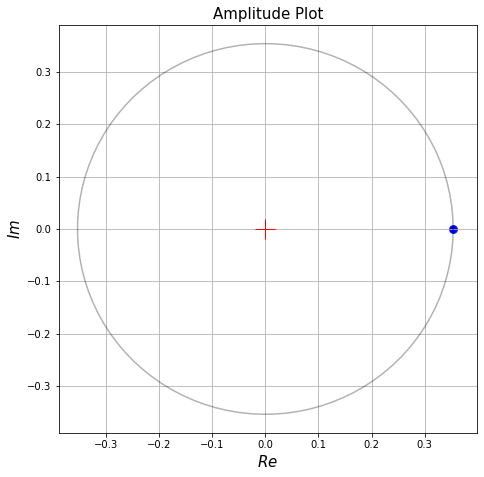

Iteration: 1


,State,Magnitude,Probability,Phase
0,|000>,0.353550,0.125000,3.141600
1,|001>,0.353550,0.125000,3.141600
2,|010>,0.353550,0.125000,3.141600
3,|011>,0.353550,0.125000,3.141600
4,|100>,0.353550,0.125000,3.141600
5,|101>,0.353550,0.125000,3.141600
6,|110>,0.353550,0.125000,3.141600
7,|111>,0.353550,0.125000,0.000000


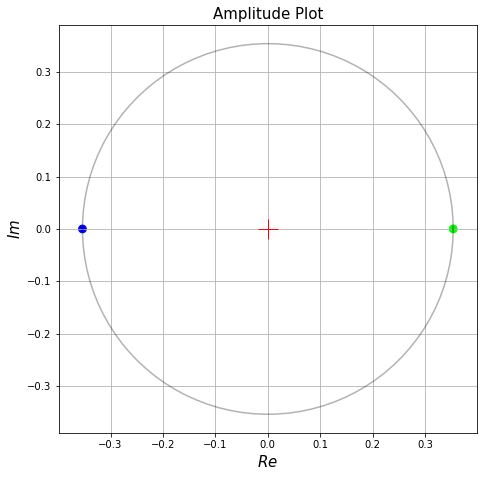

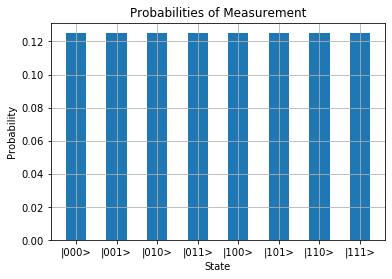

Iteration: 2


,State,Magnitude,Probability,Phase
0,|000>,0.176780,0.031250,0.000000
1,|001>,0.176780,0.031250,0.000000
2,|010>,0.176780,0.031250,0.000000
3,|011>,0.176780,0.031250,0.000000
4,|100>,0.176780,0.031250,0.000000
5,|101>,0.176780,0.031250,0.000000
6,|110>,0.176780,0.031250,0.000000
7,|111>,0.883880,0.781250,3.141600


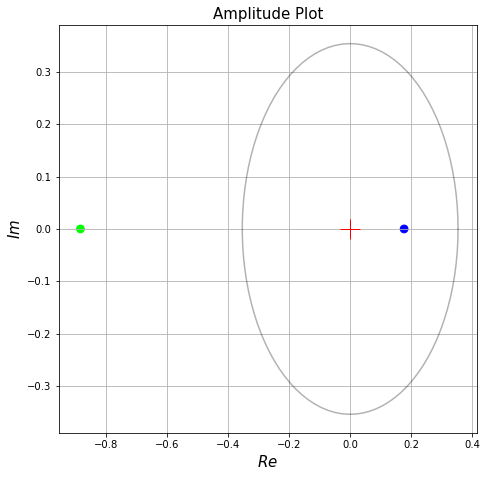

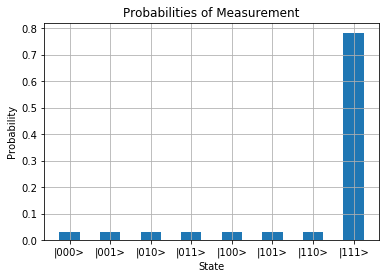

Iteration: 3


,State,Magnitude,Probability,Phase
0,|000>,0.088390,0.007810,0.000000
1,|001>,0.088390,0.007810,0.000000
2,|010>,0.088390,0.007810,0.000000
3,|011>,0.088390,0.007810,0.000000
4,|100>,0.088390,0.007810,0.000000
5,|101>,0.088390,0.007810,0.000000
6,|110>,0.088390,0.007810,0.000000
7,|111>,0.972270,0.945310,0.000000


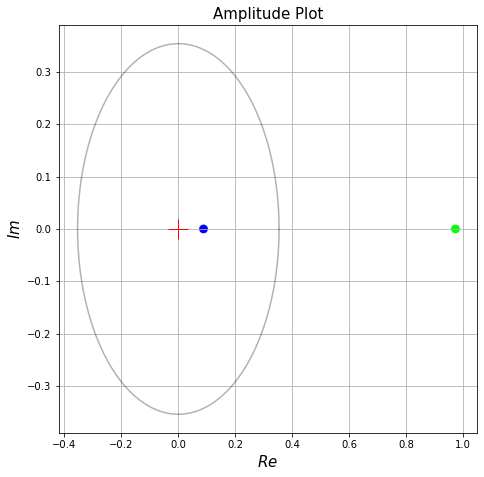

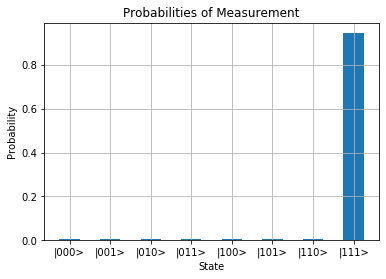

In [5]:
#------------------------------------------------------
# Quantum Circuit
#------------------------------------------------------


#------------------
num_qubits = 3 # Number of qubits

# Initializing our gates
H = H_gate(num_qubits)
X = X_gate(num_qubits)
CZ = CZ_chain_gate(num_qubits) # Oracle

# Diffusion Operator
Us = H @ X @ CZ @ X @ H

# Grover's
G = CZ @ Us

#------------------

# Initializing psi
psi = np.zeros(2**num_qubits)
psi[0] = 1


# Haddamard Transformation to achieve equal superposition state
psi = np.matmul(H, psi)
PrintPsi(psi)
PlotPsi(psi)
print('======================================================================================')

# Iterating Grover's for t iterations
t = int(np.pi/4 * np.sqrt(2**num_qubits))
for i in range(t+1):
    print('Iteration: '+str(i+1))
    psi = np.matmul(G, psi) # Applying an instance of Grovers algorithm
    PrintPsi(psi)
    PlotPsi(psi)
    ProbHist(psi)
    print('======================================================================================')